In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval

#from scipy.interpolate import spline
# jupyter nbconvert xxx.ipynb --no-input

In [2]:
figNameSvg = 'fig/v11nR08A_Defe_ctiveLifetime.svg'
figNamePng = 'fig/v11nR08A_Defe_ctiveLifetime.png'

In [3]:
Ts = 0.01

columns = ['ts','im','mt','c','xc','yc','zc','xm','ym','zm','fx','fy','fz'] 
# ts = timestep, im = motor index, mt = motor type (active = 1, defective = 2)
# c = contact  state, xc|yc|zc = binding motor head position, xm|ym|zm = binding motor root position 
# fx|fy|fz = xyz motor force at the root??
ms = pd.read_csv('dataDt1s5/MotorStates_A001_R080_273s5kd0.txt', names=columns, delim_whitespace=True)
#ms = pd.read_csv('dataDt1s5/MotorStates_A001_R08_273s5Ts00001.txt', names=columns, delim_whitespace=True)

In [4]:
# Separate active motor and defective binding motors.
ms_act = ms[ms.mt == 1]
ms_act = ms_act.reset_index(drop=True)
ms_def = ms[ms.mt == 2]
ms_def = ms_def.reset_index(drop=True)

In [5]:
act_xy = np.around( ms_act[['im','c','xm','ym']], 6).values.tolist()
def_xy = np.around( ms_def[['im','c','xm','ym']], 6).values.tolist()

## R = 0.8

#### Lifetime metric: during one lifetime, a binding motor, ($xm,ym$) must retain index '$im$', and also contact state, '$c$' in the next immediate time step '$ts$'.

In [6]:
m1lyf = {}
for i in act_xy:
    if str(i) not in m1lyf:
        m1lyf[str(i)]=0
    else:
        m1lyf[str(i)] += 1
#=========================================================        
m2lyf = {}
for i in def_xy:
    if str(i) not in m2lyf:
        m2lyf[str(i)]=0
    else:
        m2lyf[str(i)] += 1

In [7]:
m1lyftym = np.fromiter(m1lyf.values(), dtype=int) # pick dictionary values
m1lyf_Ag = pd.DataFrame({'life':m1lyftym}) # make pandas dataframe
# Make a nice list from the dictionary keys.
m1lyf_lst = []
for i in list(m1lyf.keys()):
    m1lyf_lst.append(literal_eval(i))
m1lyf_lst = np.array(m1lyf_lst) # nice list
#=========================================================   
m2lyftym = np.fromiter(m2lyf.values(), dtype=int) # pick dictionary values
m2lyf_Ag = pd.DataFrame({'life':m2lyftym}) # make pandas dataframe
# Make a nice list from the dictionary keys.
m2lyf_lst = []
for i in list(m2lyf.keys()):
    m2lyf_lst.append(literal_eval(i))
m2lyf_lst = np.array(m2lyf_lst) # nice list

In [8]:
m1Ag_mtr = pd.DataFrame({'xp':m1lyf_lst[:,2], 'yp':m1lyf_lst[:,3]}) # pandas dataframe of aggressive binding m1
m1Aglyf = pd.concat([m1Ag_mtr,m1lyf_Ag], axis=1)
m1Aglyf = m1Aglyf[m1Aglyf.life > 0]
#=========================================================   
m2Ag_mtr = pd.DataFrame({'xp':m2lyf_lst[:,2], 'yp':m2lyf_lst[:,3]}) # pandas dataframe of aggressive binding m1
m2Aglyf = pd.concat([m2Ag_mtr,m2lyf_Ag], axis=1)
m2Aglyf = m2Aglyf[m2Aglyf.life > 0]

m1Aglyf.to_csv('dataDt1s5/R080act_with_lyfkd0.csv', header=False, index=False) # x,y,life
m2Aglyf.to_csv('dataDt1s5/R080def_with_lyfkd0.csv', header=False, index=False) # x,y,life

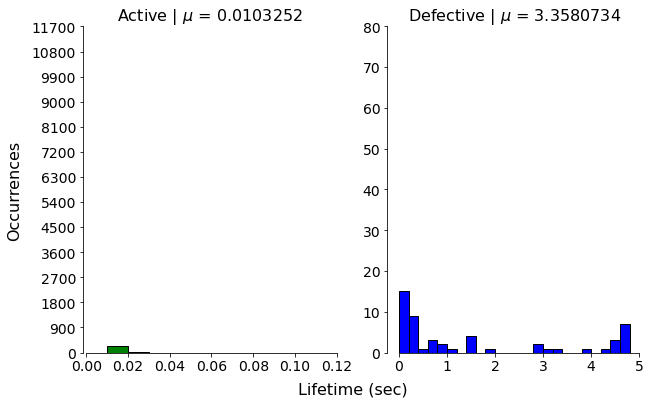

In [9]:
# Make lifetime histogram.

dt = Ts; tolerance = 0.001
act_bin_size = 0.01
act_max_lyf = round(np.max(Ts*m1Aglyf['life']), 2)
act_bins = np.arange(0.0,round(act_max_lyf+tolerance, 3),act_bin_size)
max_act_bound = 12000; m1_inc = 900

def_bin_size = 0.2
def_max_lyf = round(np.max(Ts*m2Aglyf['life']), 2)
def_bins = np.arange(0.0,round(def_max_lyf+tolerance, 3),def_bin_size)
max_def_bound = 80; m2_inc = 10


fig, ax = plt.subplots(1,2, sharex=False, sharey=False, figsize=(10,6))
#fig.add_subplot(231, frameon=False)


ax[0].hist(Ts*m1Aglyf['life'], bins=act_bins, color = 'green', ec='black', alpha=1, label='Active') # , hatch='/'
ax[0].set_xticks(np.arange(0.0,0.13,0.02))
ax[0].set_yticks(np.arange(0,max_act_bound+1,m1_inc))
ax[0].tick_params(labelsize=14)
#ax[0].set_xlabel('Lifetime (sec)', fontsize=16)
#ax[0].set_ylabel('Number of occurrences', fontsize=16)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_bounds(0,0.12)#act_max_lyf+act_bin_size)
ax[0].spines['left'].set_bounds(0,11700)
#ax[0].legend(loc='upper left')
mlyf = round(np.mean(Ts*m1Aglyf['life']), 7)
ax[0].set_title('Active | $\mu$ = %s'%mlyf, fontsize=16)

#fig.add_subplot(232, frameon=False)
#bins = np.arange(0.0,1.1,0.025)
ax[1].hist(Ts*m2Aglyf['life'], bins=def_bins, color = 'blue', ec='black', alpha=1, label='Defective')
#ax[1].set_xticks(np.arange(0.0,round(def_max_lyf+tolerance, 3),def_bin_size*4))
ax[1].set_xticks(np.arange(0.0,6,1))
ax[1].set_yticks(np.arange(0,max_def_bound+1,m2_inc))
ax[1].tick_params(labelsize=14, labelleft=True) # False -- if y scale is the same
#ax[1].set_xlabel('Lifetime (sec)', fontsize=16)
#ax[1].set_ylabel('Number of occurrences', fontsize=16)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['bottom'].set_bounds(0,5) #def_max_lyf+def_bin_size)
ax[1].spines['left'].set_bounds(0,max_def_bound)
#ax[1].legend(loc='upper left')
mlyf = round(np.mean(Ts*m2Aglyf['life']), 7)
ax[1].set_title('Defective | $\mu$ = %s'%mlyf, fontsize=16)

fig.text(0.5,0.04, 'Lifetime (sec)', fontsize=16, va='center', ha='center')
fig.text(0.03,0.5, 'Occurrences', fontsize=16, va='center', ha='center', rotation='vertical')

plt.subplots_adjust(hspace=0.3)

#plt.savefig(figNameSvg, fmt='.svg', dpi=1200, bbox_inches='tight')
#plt.savefig(figNamePng, fmt='.png', dpi=1200, bbox_inches='tight')

plt.show()

In [22]:
!jupyter nbconvert V11nLifetimeR08_dt1s5kd.ipynb --no-input --to html

[NbConvertApp] Converting notebook V11nLifetimeR08_dt1s5.ipynb to html
[NbConvertApp] Writing 596237 bytes to V11nLifetimeR08_dt1s5.html
